# Alumno: Gerardo de Miguel González

## Ejercicio de regularización

### Horner Gaussiano

 1. Escribe una función de R que reciba como input un vector "x" con la variable dependiente, un vector de parámetros "betas" que contenga los coeficientes de un polinomio y una sigma "sigma"; y que devuelva el vector dependiente que siga la ley polinomial dada con PDF gaussiana y sigma dada.  

In [1]:
#::GMG::Algoritmo de Horner vectorizado para hallar el valor de un polinomio
#       x: variable independiente
#       v: vector de coeficientes en x^0, x^1, ..., x^p
horner <- function(x, v) {
  Reduce(v, right=T, f=function(a, b) {
    b * x + a
  })
}

In [2]:
#::GMG::Función que genera el polinomio junto con un ruido distribuido
#       N(0,sigma)
pol <- function (x,betas,sigma) {
    return(horner(x,betas) + rnorm(length(x),0,sigma))
}

 2. Construye un vector de 40 elementos distribuido uniformemente entre [-3, 3]. Úsalo con la función anterior, el polinomio: $x^3 + 2 x^2 - x - 2$ y $\sigma = 4$. Representa los datos resultantes.

**::GMG::** Los `ISSUE` en los comentarios son el feedback del profesor; las líneas de código comentadas son las que he corregido derivadas de los comentarios recibidos.

In [3]:
#::GMG::Nube de puntos del polinonio solicitado con el ruido gaussiano
#::ISSUE::No has tomado tus abscisas de forma aleatoria, y tampoco tu división
#entre train y test lo es. De esta forma, la validación cruzada es muy
#artificial. No ya por usar un hold out, sino porque no es aleatorio
#::ISSUE::No has cogido los 40 puntos pedidos, sino 41. ¿Por qué usas el número
#mágico by=6/40? Prueba el argumento length.out
#x <- seq(from = -3, to = 3, by = 6/40)
x <- seq(from = -3, to = 3, length.out = 40)

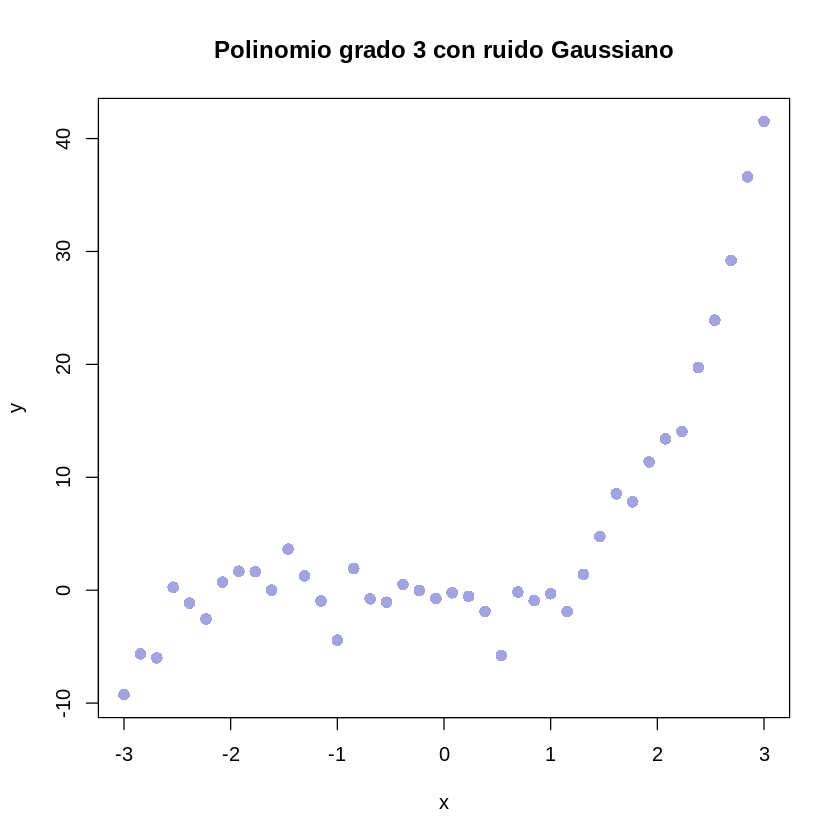

In [4]:
beta <- c(-2,-1,2,1)
sigma <- 2
set.seed(1)
y <- pol(x,beta,sigma)
plot(x,y, 
     col=rgb(0.4,0.4,0.8,0.6),
     pch=16 ,cex=1.3, 
     main = 'Polinomio grado 3 con ruido Gaussiano')

 3. Calcula el valor mínimo de la función de coste (_loss_, RSS) para el caso en que hacemos un ajuste con una recta (dos parámetros), una parábola (tres parámetros), 4, 5, 6 y 7 parámetros, usando los primeros 20 puntos. Con los valores que hacen mínimo el RSS para la muestra de entrenamiento, calcula el RSS para los siguientes 20 puntos. Pinta los resultados en función del número de parámetros para ambos casos.

### Función de coste

In [5]:
#::GMG::Defino la función de coste (loss, rss)
#::nota::beta es el vector de coeficientes de regresión, i.e 
#        beta_0, beta_1, ... beta_p de x_0, x_1, ... x_p o x^0, x^1, ..., x^p
#        x son las 'features' de la matriz de diseño (1,x)
rss <- function(betas,x,y) {
    betas.m <- as.matrix(betas)
    y.m <- as.matrix(y)
    X <- as.matrix(cbind(1,x))
    return (as.numeric(t(y.m - X %*% betas.m) %*% (y.m - X %*% betas.m)))
}

### Train/Test

In [10]:
#::GMG::Selecciono los "primeros 20 puntos" como "train"
#::ISSUE::No has tomado tus abscisas de forma aleatoria, y tampoco tu división
#entre train y test lo es. De esta forma, la validación cruzada es muy
#artificial. No ya por usar un hold out, sino porque no es aleatorio
#::ISSUE::La división que proponía al 50% es para no liarnos con el tamaño de
#muestra. Por ejemplo, el RSS depende del tamaño de muestra. Cuanto mayor
#es la muestra, mayor es en general el RSS ya que no está normalizado.
#Tomando mitad y mitad, son comparables los RSS de train y test (prueba a
#dibujarlos en la misma gráfica). En una situación más realista, haríamos
#un k-fold en lugar de un hold-out.
#mitad <- 1:20
#x_train <- x[mitad]
#y_train <- y[mitad]
#x_test <- x[-mitad]
#y_test <- y[-mitad]
#::nota:: hold-out validation correctly: splitting the dataset into 2 parts 
#         and using one for training and the other for testing
# https://stackoverflow.com/questions/17200114/how-to-split-data-into-training-testing-sets-using-sample-function
# https://stat.ethz.ch/R-manual/R-devel/library/base/html/sample.html
set.seed(1)
#::GMG::hold-out 50%  
sample <- sample.int(n = length(x), 
                     size = floor(0.50*length(x)), 
                     replace = F)
x_train <- x[sample]
y_train <- y[sample]
x_test  <- x[-sample]
y_test  <- y[-sample]

In [7]:
#::GMG::Hablamos primero de una regresión lineal con intercept y slope
#       La hago primero de forma "manual": calculo los dos parámetros
#::nota::caso recta, i.e polinomio de grado 1

#::ISSUE::Desde el punto de vista, no ya de data scientist profesional, sino de
#programación, trata de programar funciones más genéricas. Por ejemplo,
#separas el ajuste a una recta del ajuste a un polinomio de grado n. La
#recta es un caso particular de éste. Después tendrás que hacer lo mismo
#con regularización. Pero el caso sin regularización es también un caso
#particular de éste (con lambda=0). El código se simplifica mucho de esta
#manera, y se entiende mejor el efecto del orden del polinomio y del
#papel de lambda.

#X <- cbind(rep(1,20), x_train)
#Y <- matrix(y_train, nrow=length(y_train))
#b_hat <- solve(t(X)%*%X)%*%t(X)%*%Y
#b_0_hat <- b_hat[1,1]
#b_1_hat <- b_hat[2,1]
#p_lm <- c(b_0_hat,b_1_hat)
#names(p_lm) <- c('intercept','x_train')
#print(p_lm)
#paste('rss:', round(rss(betas = p_lm, x = x_train, y = y_train),2))

### Regresión Matricial Polinomial (n parámetros)

In [8]:
#::GMG::Calculo la función que resuelve 'least squares' las betas de forma matricial
#       en una regresión lineal simple
betas <- function(x,y) {
    X <- cbind(1,x)
    Y <- as.matrix(y)
    b <- t(solve(t(X) %*% X) %*% t(X) %*% Y)
    #colnames(b) <- c('intercept', 'slope')
    return (as.numeric(b))
}

In [9]:
#::GMG::Prueba de funionamiento
#m <- betas(x = x_train, y = y_train)
#print(round(m,2))

In [11]:
#::GMG::Me hago mi función de regresión lineal con rss() y betas()
mi_lm <- function(x,y) {
    coef <- betas(x = x,y = y)
    loss <- rss(betas = coef,x = x,y = y)
    list(coeficientes = coef, rss = loss)
}

In [12]:
#::GMG::Prueba de funcionamiento
#mi_model <- mi_lm(x = x_train, y = y_train)
#round(mi_model$coeficientes,2)
#paste('rss:',round(mi_model$rss,2))
#model <- lm(y_train~x_train)
#print(round(model$coefficients,3))
#paste('rss:',round(sum(model$residuals^2),2),
#      '(', round(rss(betas = model$coefficients, x = x_train, y = y_train),2), ')')

[1] 5.93 5.07

[1] "rss: 986.47"

In [15]:
#::GMG::Usamos la función poly() para construir los polinomios de regresión
#       i.e. x^1, x^2, ..., x^p de la matriz de diseño para los betas
# https://www.rdocumentation.org/packages/stats/versions/3.5.1/topics/poly
x_3 <- cbind(x_train^1,x_train^2,x_train^3)
head(x_3)

-1.4615385,2.13609467,-3.12198452
-0.8461538,0.71597633,-0.60582613
0.2307692,0.05325444,0.01228949
2.0769231,4.31360947,8.95903505
-1.9230769,3.69822485,-7.11197087
1.7692308,3.13017751,5.53800637


In [16]:
x_3_b <- poly(x_train, 3,raw = T)
head (x_3_b)

1,2,3
-1.4615385,2.13609467,-3.12198452
-0.8461538,0.71597633,-0.60582613
0.2307692,0.05325444,0.01228949
2.0769231,4.31360947,8.95903505
-1.9230769,3.69822485,-7.11197087
1.7692308,3.13017751,5.53800637


In [18]:
#::GMG::Prueba de funcionamiento
mi_model <- mi_lm(x = poly(x_train, 1,raw = T), y = y_train)
round(mi_model$coeficientes,2)
paste('rss:',round(mi_model$rss,2))

[1] 5.93 5.07

[1] "rss: 986.47"

In [ ]:
#::GMG::La regresión lineal simple se puede hacer con lm()
#::ISSUE::este problema lo planteaba para hacerlo
#sin lm(). Hasta el momento te ha servido, pero lm() no tiene
#implementada la regularización que viene a continuación.
#model_1 <- lm(y_train~x_train)
#print(round(model_1$coefficients,3))

#::GMG:: El valor de loss/rss lo puedo calcular aquí con los 'residuos' 
#        que proporciona el objeto model_1
#paste('rss:',round(sum(model_1$residuals^2),2),
#      '(', round(rss(betas = model_1$coefficients, x = x_train, y = y_train),2), ')')

In [ ]:
#::GMG::para el caso polinomial se puede usar lm() e I()
# https://www.rdocumentation.org/packages/base/versions/3.5.1/topics/AsIs
#model_2 <- lm(y_train~x_train + I(x_train^2))
#print(round(model_2$coef,2))
#paste('rss:',round(sum(model_2$residuals^2),2) ,
#      '(', round(rss(betas = model_2$coefficients, 
#                     x = cbind(x_train, x_train^2), 
#                     y = y_train),2), ')'
#)

In [ ]:
#::GMG::Que es equivalente, usando lm() e poly()
# https://www.rdocumentation.org/packages/stats/versions/3.5.1/topics/poly
#model_2_b <- lm(y_train~poly(x_train, 2,raw = T))
#print(round(as.vector(t(model_2_b$coef)),2))
#paste('rss:',round(sum(model_2_b$residuals^2),2) ,
#      '(', round(rss(betas = model_2_b$coefficients, 
#                     x = cbind(x_train, x_train^2), 
#                     y = y_train),2), ')'
#)

### Resultados

In [ ]:
#::GMG::Usando lm(), poly() y residuals calculo y pinto los rss
#       con polinomios de grado 2 a 7 para los 20 puntos de train

#::ISSUE::este problema lo planteaba para hacerlo
#sin lm(). Hasta el momento te ha servido, pero lm() no tiene
#implementada la regularización que viene a continuación.

# https://stackoverflow.com/questions/13444524/populating-a-list-with-lm-objects
#model <- list()
#loss <- c()
##for (i in 1:7) {
##    model[[i]] <- lm(y_train~poly(x_train, i,raw = T)) 
##    loss[i] <- sum(model[[i]]$residuals^2)
##}
#for (i in 1:7) {
#    model[[i]] <- lm(y_train~poly(x_train, i,raw = T)) 
#    loss[i] <- rss(betas = model[[i]]$coefficients, 
#                   x = poly(x = x_train,degree = i, raw = T), 
#                   y = y_train)
#}
#model[[1]]
#loss

In [ ]:
# ::GMG::Pintamos los diferentes modelos que hemos obtenido en train 
#plot(x_train,y_train, pch = 16, cex = 1.3, col = "blue")
#for (i in 1:7) {
#  points(x_train, fitted(model[[i]]), col=i+1, pch=20, type='b')
#}

In [ ]:
#::GMG::Hago la predicción para los puntos de test
#loss_pred <- c()
#pred <- list()
#for (i in 1:7) {
#    pred[[i]] <- predict(model[[i]], newdata = data.frame(x_test,y_test))
#    loss_pred[i] <- rss(betas = model[[i]]$coefficients, 
#                        x = poly(x = x_test,degree = i, raw = T), 
#                        y = y_test)
#}

In [ ]:
# https://stackoverflow.com/questions/47890742/logarithmic-scale-plot-in-r
#log10Tck <- function(side, type){
#   lim <- switch(side, 
#     x = par('usr')[1:2],
#     y = par('usr')[3:4],
#     stop("side argument must be 'x' or 'y'"))
#   at <- floor(lim[1]) : ceiling(lim[2])
#   return(switch(type, 
#     minor = outer(1:9, 10^(min(at):max(at))),
#     major = 10^at,
#     stop("type argument must be 'major' or 'minor'")
#   ))
#}

In [ ]:
#::GMG::Dibujo la evolución de rss en función del grado para el test
# https://stackoverflow.com/questions/47890742/logarithmic-scale-plot-in-r
# http://www.sthda.com/english/wiki/axis-scale-in-r-software-minimum-maximum-and-log-scale
# https://stat.ethz.ch/pipermail/r-help/2010-March/232593.html
#plot(1:7,loss_pred, log='y', axes = F,
#     type = 'b', col = 'red', 
#     xlab = 'grado', ylab = 'log(loss/rss) Test',
#     panel.first=abline(v=c(1,2,3,4,5,6,7),
#                        h=c(1e+04,1e+05,1e+06,1e+07,1e+08,1e+09), 
#                        lty=3,
#                        col="gray"),
#     main = 'RSS/Loss Test regresión lineal polinomial')
#axis(1) # normal x axis
#axis(2, at=log10Tck('y','major'), tcl= 0.2)
#axis(2, at=log10Tck('y','minor'), tcl= 0.1, labels=NA)

In [ ]:
#::GMG::Pinto los modelos obtenidos para el test 
#plot(x_test,y_test, pch = 16, cex = 1.3, col = "blue")
#for (i in 1:7) {
#  points(x_test, pred[[i]], col=i+1, type = 'b')
#}

In [22]:
#::GMG::calculo y pinto los rss para el train com mi_lm() hasta grado 7
model <- list()
loss <- c()
for (i in 1:7) {
    model[[i]] <- mi_lm(x = poly(x_train, i,raw = T), y = y_train) 
    loss[i] <- model[[i]]$rss
}

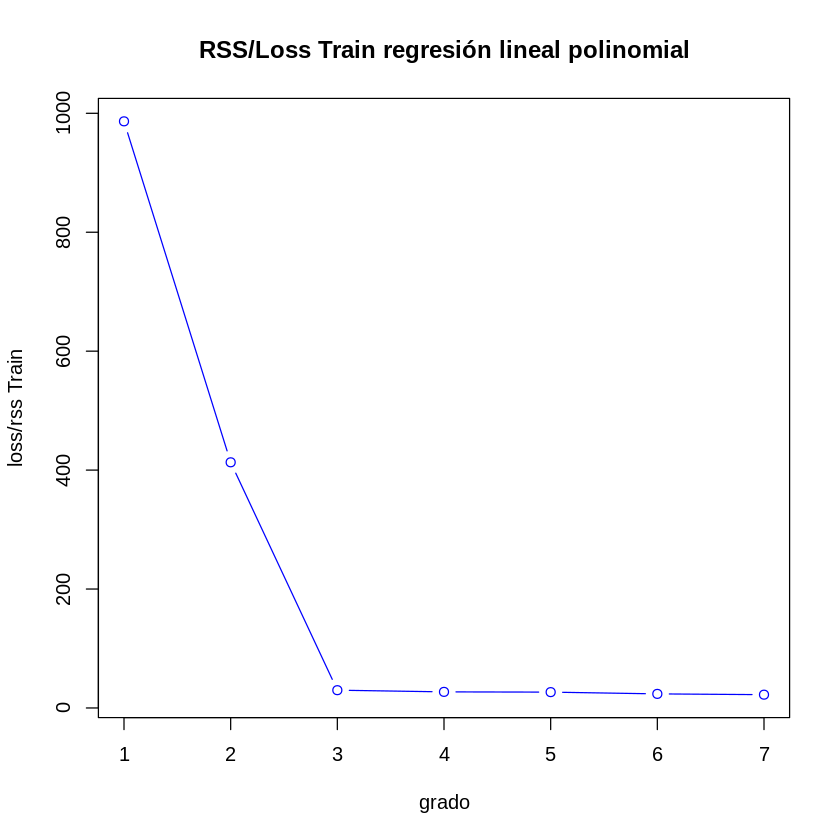

In [23]:
#::GMG::Dibujo la evolución de rss en función del grado
plot(1:7,loss, type = 'b', col = 'blue', 
     xlab = 'grado', ylab = 'loss/rss Train', 
     main = 'RSS/Loss Train regresión lineal polinomial')

In [61]:
#::GMG::Hago mi función predict con horner() y rss()
mi_predict <- function (model,x,y) {
    coef <- model$coeficientes
    y_p <- horner(x = x, v = coef)
    loss <- sum((y - y_p)^2)
    #::nota::no me funciona (?)
    #loss <- rss(betas = coef,x = x,y = y)
    list(y_pred = y_p, rss = loss)
}

In [65]:
#::GMG::Hago la predicción en el conjunto de test para los modelos
p <- list()
loss <- c()
for (i in 1:7) {
    p[[i]] <- mi_predict(model = model[[i]],x_test, y_test)
    loss[i] <- p[[i]]$rss
}

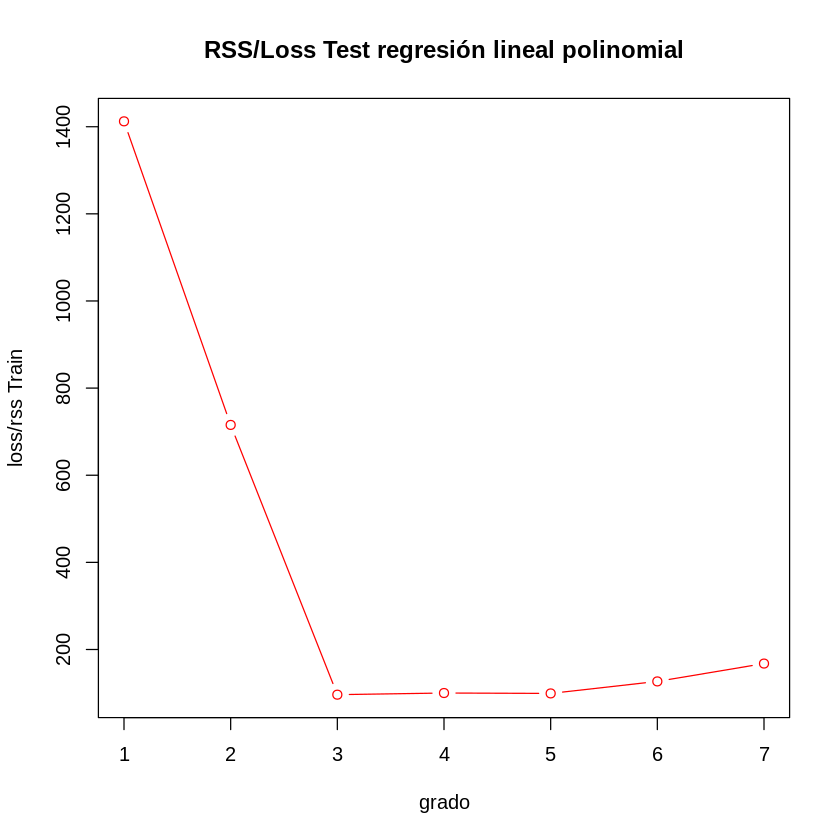

In [67]:
#::GMG::Dibujo la evolución de rss en función del grado
plot(1:7,loss, type = 'b', col = 'red', 
     xlab = 'grado', ylab = 'loss/rss Train', 
     main = 'RSS/Loss Test regresión lineal polinomial')

 4. Escribe una función de R que encuentre el mínimo de la función de coste para el caso de regularización L2. El parámetro lambda será pasado como input. Utilízala para estimar las curvas que mejor ajustan para el caso de (4 parámetros, lambda = 0), (7 parámetros, lambda=0) y (7 parámetros, lambda=1000). Pinta todas las curvas juntas y escribe tus conclusiones. 

5. Utiliza la función anterior para representar el valor de los parámetros del modelo en función de $\lambda$. Prueba a representar la evolución de los coeficientes de un modelo de 11 parámetros.